In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ClassLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, pred, label, have_label):
        pred = pred.view(-1, 3)
        label = label.view(-1, 3)
        have_label = have_label.view(-1)
        pred = pred[have_label]
        label = label[have_label]

        label_weights = torch.tensor([2 ** x.tolist().index(1) for x in label], device=pred.device) ## 2 ** index == (1, 2, 4)
        loss = self.loss(pred, label)
        loss *= label_weights
        loss = loss.mean()
        return loss, {}

class LocsLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.MSELoss()

    def forward(self, pred, label, have_label):
        pred = pred.view(-1, 3)
        label = label.view(-1, 3)
        have_label = have_label.view(-1)
        pred = pred[have_label]
        label = label[have_label]

        loss_z = self.loss(pred[:, 0], label[:, 0])
        loss_xy = self.loss(pred[: , 1 : ], label[: , 1 : ])


        return loss_z + loss_xy, {'loss_z' : loss_z, 'loss_xy' : loss_xy}

class JensonShannonDiv(nn.Module):
    def forward(self, pred, label, dims, have_label):
        pred = pred.permute(1, 0, 2, 3)
        label = label.permute(1, 0, 2, 3)

        heatmap =  torch.split_with_sizes(pred, dims, 0)
        truth =  torch.split_with_sizes(label, dims, 0)
        num_image = len(heatmap)

        loss =0
        for i in range(num_image):
            p,q = truth[i], heatmap[i]
            p, q = p[:, have_label[i]], q[:, have_label[i]]
            D,num_point,H,W = p.shape

            eps = 1e-8
            p = torch.clamp(p.transpose(1,0).flatten(1),eps,1-eps)
            q = torch.clamp(q.transpose(1,0).flatten(1),eps,1-eps)
            m = (0.5 * (p + q)).log()

            kl = lambda x,t: F.kl_div(x,t, reduction='batchmean', log_target=True)
            loss += 0.5 * (kl(m, p.log()) + kl(m, q.log()))
        loss = loss/num_image
        return loss, {}


class CustomLoss(nn.Module):
    def __init__(self, epoch):
        super().__init__()
        self.class_loss = ClassLoss()
        self.locs_loss = LocsLoss()
        self.js_div = JensonShannonDiv()
        
        locs_loss_finish_value = 0.001
        js_div_finish_value = 0.001
        
        self.class_loss_schedule = [1 for i in range(epoch)]
        self.locs_loss_schedule = [0.01 - i * ((0.01 - locs_loss_finish_value) / epoch) for i in range(epoch)]
        self.js_div_schedule = [0.2 - i * ((0.2 - js_div_finish_value) / epoch) for i in range(epoch)]

    def forward(self, pred, label, epoch):
        class_loss, dict0 = self.class_loss(pred['grade'], label['label'], label['have_label'])
        locs_loss, dict1 = self.locs_loss(pred['coordinates'], label['coordinates'], label['have_label'])
        js_div, dict2 = self.js_div(pred['mask'], label['seg_label'], label['dims'].tolist(), label['have_label'])

        result_dict = {'class_loss' : class_loss, 'locs_loss' : locs_loss, 'js_div' : js_div, **dict0, **dict1, **dict2}
        result_dict = {k : v.detach() for k, v, in result_dict.items()}

        #return locs_loss / (96 ** 2) + js_div, result_dict
        return (class_loss * self.class_loss_schedule[epoch] + 
                locs_loss * self.locs_loss_schedule[epoch] + 
                js_div * self.js_div_schedule[epoch], 
                result_dict)


In [20]:
sample_truth = {
    'label': torch.tensor([[1, 0, 0]] * 10, dtype=torch.float32),
    'coordinates': torch.rand(1, 10, 3),
    'seg_label': torch.rand(10, 10, 64, 64),
    'have_label': torch.ones(1, 10, dtype=torch.bool),
    'dims': torch.tensor([10], dtype=torch.int)
}
sample_pred = {
    'grade': torch.rand(1, 10, 3),
    'coordinates': torch.rand(1, 10, 3),
    'mask': torch.rand(10, 10, 64, 64),
}
loss = CustomLoss(15)
print(loss(sample_pred, sample_truth, 0))

(tensor(420.3250), {'class_loss': tensor(1.2124), 'locs_loss': tensor(0.2433), 'js_div': tensor(2095.5503), 'loss_z': tensor(0.1291), 'loss_xy': tensor(0.1142)})


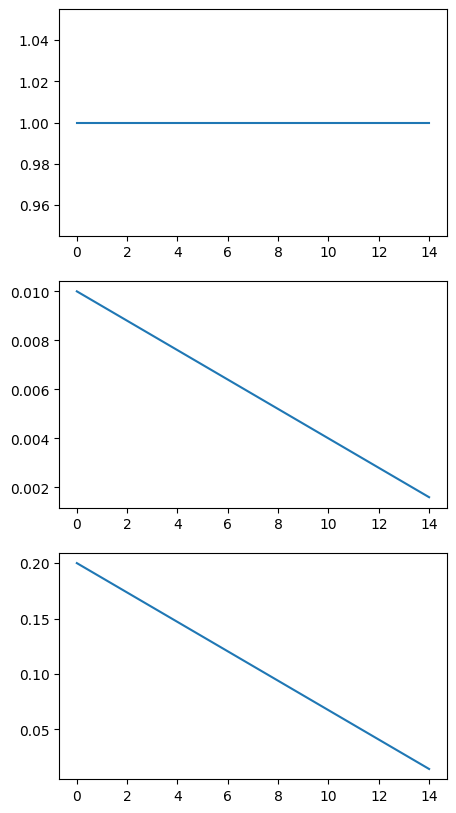

In [21]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(3, figsize=(5, 10))

ax[0].plot(loss.class_loss_schedule)
ax[1].plot(loss.locs_loss_schedule)
ax[2].plot(loss.js_div_schedule)
